In [2]:
# Boston Housingデータセットの読み込み
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [5]:
train_targets[:5]

array([15.2, 42.3, 50. , 21.1, 17.7])

In [6]:
# データの正規化
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [7]:
# モデルの定義
from keras import models
from keras import layers

In [8]:
def build_model():
    # 同じモデルを複数回インスタンス化するため、
    # モデルをインスタンス化する関数を作成
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                                                  input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [9]:
import numpy as np

In [10]:
# k分割交差検証

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    
    # 検証データの準備
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # 訓練データの準備
    partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)
    partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0)
    
    # モデルを構築
    model = build_model()
    
    # モデルをサイレントモードで適合
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    # モデルを検証データで評価
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
all_scores

[1.9800115328023928, 2.262345894728557, 3.019325053337777, 2.3518412561699895]

In [12]:
np.mean(all_scores)

2.403380934259679

In [13]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    # 検証データの準備
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # 訓練データの準備
    partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)
    partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0)
    
    # モデルを構築
    model = build_model()
    
    # モデルをサイレントモードで適合
    history = model.fit(partial_train_data, partial_train_targets, 
                     validation_data=(val_data, val_targets), 
                     epochs=num_epochs, batch_size=1, verbose=0)
    
    # モデルを検証データで評価
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
print('finish!')

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
finish!


In [14]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

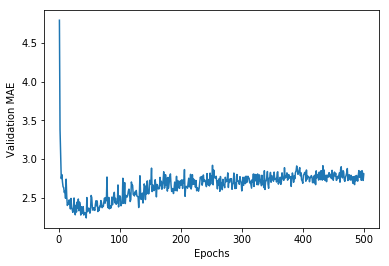

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

In [22]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

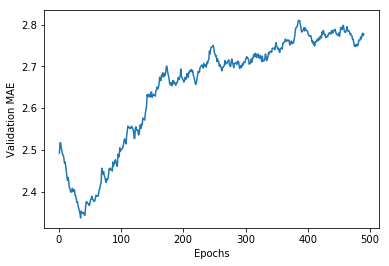

In [23]:
smoothed_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smoothed_mae_history) + 1), smoothed_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

In [24]:
# 最終的なモデルの訓練
model = build_model()

# データ全体を使って訓練
model.fit(train_data, train_targets,
                 epochs=80, batch_size=16, verbose=0)

# テストデータの検証スコア
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

102/102 [==============================] - 0s 899us/step
2.688163719925226
